This notebook is a rough guide showing how I downloaded and plotted humidity data from MERRA-2.

# Downloading the data

To get the dataset, I started at https://disc.gsfc.nasa.gov/datasets?keywords=%22MERRA-2%22&page=1&source=Models%2FAnalyses%20MERRA-2. I filtered for datasets with Atmospheric Water Vapor and 1- or 3-hour measurements. 

I didn't know how to tell the difference between all of these datasets, so I picked this one:
```
M2I3NVASM: MERRA-2 inst3_3d_asm_Nv: 3d,3-Hourly,Instantaneous,Model-Level,Assimilation,Assimilated Meteorological Fields
```
This source gives pretty large data files because the data is 3D at each time. I think a 2D source would be easier to work with, but I don't know which ones have which variables.

Then, I got to choose a subset of the data. This includes:
- Dates (I picked all of 2019)
- Region (I drew a box roughly around India)
- Variables (I used the default, which downloads all of them)
- Times of day (I picked "daily mean")
- Grid (I used the default)
- File format (I picked NetCDF)

The site gave me a list of download links -- one per day. I had to set up an Earthdata account to download any of them. They also gave me instructions on how to use `wget` or `curl` to automatically download all of the files; I just downloaded the first one.

# Plotting the data

I found these links helpful for learning how to work with NetCDF files:
- python-netcdf4 docmentation: https://unidata.github.io/netcdf4-python/netCDF4/index.html
- Example of loading an existing dataset: http://schubert.atmos.colostate.edu/~cslocum/netcdf_example.html


In [1]:
# Library for loading netCDF data files
import netCDF4

# Plotting library
import matplotlib.pyplot as plt

In [2]:
# Extra settings to make my plots look pretty
import matplotlib
matplotlib.rcParams['figure.dpi'] = 180
matplotlib.rcParams['font.size'] = 8

In [3]:
# Open the file (netCDF's equivalent of `open`)
# TODO: ideally, this would look like
# > with netCDF4.Data(...) as nc_file:
# to make sure the file gets closed after loading the data
nc_file = netCDF4.Dataset('data/MERRA2_400.inst3_3d_asm_Nv.20190101.SUB.nc', 'r')

In [4]:
# Find what's included in the dataset

# Sample of top-level attributes -- these weren't very helpful to me
display(nc_file.ncattrs()[:20])

# How to access one of these
display(nc_file.SouthernmostLatitude)

['CDI',
 'history',
 'Conventions',
 'History',
 'Comment',
 'Filename',
 'Institution',
 'References',
 'Format',
 'SpatialCoverage',
 'VersionID',
 'TemporalRange',
 'identifier_product_doi_authority',
 'ShortName',
 'GranuleID',
 'ProductionDateTime',
 'LongName',
 'Title',
 'SouthernmostLatitude',
 'NorthernmostLatitude']

'-90.0'

In [5]:
# Dimensions for each of the variables
# This file is 3D, so for every time, we can pick:
# - lev: z coordinate, ranging from 0 (top of atmosphere) to 71 (surface level)
# - lat: y coordinate
# - lon: x coordinate
# I guess some of the variables have 2 bands, too
display(nc_file.dimensions)

OrderedDict([('time',
              <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 1),
             ('lev',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'lev', size = 72),
             ('lat',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 63),
             ('lon',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 46),
             ('bnds',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'bnds', size = 2)])

In [6]:
# List the actual variables in this dataset
# Note that the last few variables describe the dimensions (lat/lev/lon/time/time_bnds)
display(list(var for var in nc_file.variables))

['CLOUD',
 'DELP',
 'EPV',
 'H',
 'O3',
 'OMEGA',
 'PHIS',
 'PL',
 'PS',
 'QI',
 'QL',
 'QV',
 'RH',
 'SLP',
 'T',
 'U',
 'V',
 'lat',
 'lev',
 'lon',
 'time',
 'time_bnds']

In [7]:
# Get specific info for one variable
# This one shows that humidity is a function of time, level, lat, and lon
# standard_name, units, and shape are also useful 
display(nc_file.variables['RH'])

<class 'netCDF4._netCDF4.Variable'>
float32 RH(time, lev, lat, lon)
    standard_name: relative_humidity_after_moist
    long_name: relative_humidity_after_moist
    units: 1
    _FillValue: 1000000000000000.0
    missing_value: 1000000000000000.0
    fmissing_value: 1000000000000000.0
    vmax: 1000000000000000.0
    vmin: -1000000000000000.0
unlimited dimensions: time
current shape = (1, 72, 63, 46)
filling on

In [8]:
# Get data on useful variables
rh = nc_file.variables['RH'][:]
lat = nc_file.variables['lat'][:]
lon = nc_file.variables['lon'][:]

In [9]:
# Humidity at one time and height
# (index order is rh[time][lev][lat][lon])
display(rh[0][71][:][:])

masked_array(
  data=[[0.68653816, 0.6782984 , 0.6787867 , ..., 0.75923103, 0.76933235,
         0.76795906],
        [0.6821131 , 0.67347664, 0.67594856, ..., 0.73979133, 0.76536506,
         0.75767463],
        [0.6770472 , 0.6756739 , 0.6739039 , ..., 0.7389979 , 0.7487635 ,
         0.7455897 ],
        ...,
        [0.80509895, 0.8305201 , 0.8784022 , ..., 0.31071037, 0.2654299 ,
         0.24493355],
        [0.7636866 , 0.7845606 , 0.81965584, ..., 0.23248237, 0.20172447,
         0.20016044],
        [0.7078089 , 0.74571174, 0.7202448 , ..., 0.18743843, 0.1972155 ,
         0.24537987]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [10]:
# List of latitudes and longitudes
display(lat)
display(lon)

masked_array(data=[ 6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
                   11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. ,
                   15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5,
                   20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. ,
                   24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5, 28. , 28.5,
                   29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5, 33. ,
                   33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5],
             mask=False,
       fill_value=1e+20)

masked_array(data=[65.   , 65.625, 66.25 , 66.875, 67.5  , 68.125, 68.75 ,
                   69.375, 70.   , 70.625, 71.25 , 71.875, 72.5  , 73.125,
                   73.75 , 74.375, 75.   , 75.625, 76.25 , 76.875, 77.5  ,
                   78.125, 78.75 , 79.375, 80.   , 80.625, 81.25 , 81.875,
                   82.5  , 83.125, 83.75 , 84.375, 85.   , 85.625, 86.25 ,
                   86.875, 87.5  , 88.125, 88.75 , 89.375, 90.   , 90.625,
                   91.25 , 91.875, 92.5  , 93.125],
             mask=False,
       fill_value=1e+20)

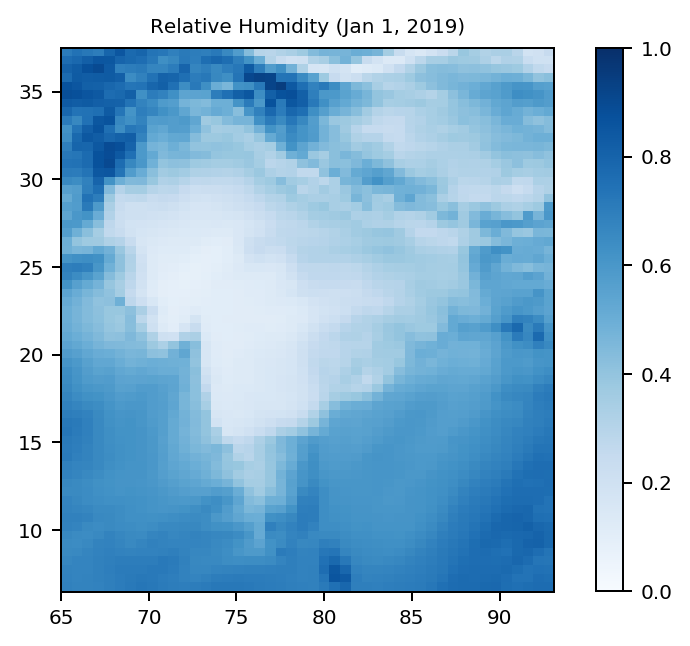

In [11]:
# Heatmap of relative humidity
plt.figure()
plt.imshow(
    rh[0][71], # Relative humidity at time 0 and level 71 (surface)
    cmap='Blues', 
    vmin=0, # min value in plot
    vmax=1, # max value in plot
    origin='lower', # Put y=0 at bottom instead of top
    extent=[65, 93.125, 6.5, 37.5] # min/max lat and long. TODO: read from lat/lon variables
)
plt.colorbar()
plt.title('Relative Humidity (Jan 1, 2019)', fontsize=8)
plt.show()